In [36]:
# Import modules

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import os
import glob
import wfdb
import keras
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from predict import get_sample_beat, generate_grad_cam, ACTUAL_CLASS_MAPPING
from zone_classifier import default_zone_policy
zone, explanation = default_zone_policy(predicted_label, confidence / 100)
print(zone, explanation)

NameError: name 'predicted_label' is not defined

In [39]:
# First we will store the paths of the ECG signals. 
# According to the Association for the Advancement of Medical Instrumentation (AAMI) recommended practice, the 4 paced beats are excluded in this experimental evaluation process because these beats do not retain sufficient signal quality for reliable processing. 
# Also, the paced beats are from the pacemakers.

In [8]:
DATASET_PATH = './mitdb'
header_path = os.path.join(DATASET_PATH, '*hea')
paths = glob.glob(header_path)

# Remove the extension and store the path
paths = [path[:-4] for path in paths]

# Remove paced beat record
remove_paced_beats = ['102', '104', '107', '217']

# Store the data path
data_paths = [path for path in paths if path[-3:] not in remove_paced_beats]

train_data = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', 
              '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']

train_data_paths = [path for path in data_paths if path[-3:] in train_data]

test_data = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', 
             '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

random.seed(42)
random.shuffle(test_data)
validation_data_paths = [path for path in data_paths if path[-3:] in test_data[:-5]]
test_data_paths = [path for path in data_paths if path[-3:] in test_data[-5:]]

In [41]:
# The beats of interest are:

# class E: contains ventricular escape (E) beats.
# class F: contains fusion of ventricular and normal (F) and fusion of paced and normal (f) beats.
# class N: contains normal beat (N), left bundle branch block (L), right bundle branch block (R), atrial premature (A), aberrated atrial premature (a), nodal premature (J), supraventricular premature (S), atrial escape (e) and nodal escape (j) beats.
# class V: contains premature ventricular contraction (V) beats.

In [9]:
# Generate 50 sequences from both sides of the sample

def sequences(symbol, signal, sample, signal_length):
    non_beat_annotations = ["[", "!", "]", "x", "(", ")", "p", "t", "u", "`", "'",
                        "^", "|", "~", "+", "s", "T", "*", "D", "=", '"', "@"]
    
    # Following beats are considered for the analysis
    beat_annotations = ["N", "L", "R", "A", "a", "J", "S", "V", "F", "e", "j", "E", "f"]
    
    start = sample - 50
    end = sample + 50
          
    if symbol in beat_annotations and start > 0 and end < signal_length:
        signal_lead_0 = signal[start:end,0].reshape(1,-1,1)
        signal_lead_1 = signal[start:end,1].reshape(1,-1,1)
        
        return signal_lead_0,signal_lead_1,symbol
    
    else:
        return [], [], []

In [10]:
# Scale the data
def preprocess(signal):
    scaler = StandardScaler()
    scaled_signal = scaler.fit_transform(signal)
    return scaled_signal

In [11]:
# Train, Validation and Test data and labels

def generate_data(path):
    signal_channel_0 = []
    signal_channel_1 = []
    labels_channel_0 = []
    labels_channel_1 = []
    
    for file in path:
        # Load the ECG signal from 2 leads
        record = wfdb.rdrecord(file)
        
        # Check the frequency is 360
        assert record.fs == 360, 'sample frequency is not 360'
        scaled_signal = preprocess(record.p_signal)
        signal_length = scaled_signal.shape[0]
        annotation = wfdb.rdann(file, 'atr')
        samples = annotation.sample
        symbols = annotation.symbol
    
        N = ['.', 'N', 'L', 'R', 'A', 'a', 'J', 'S', 'e', 'j']
        
        for i, sample in enumerate(samples):
            signal_0, signal_1, valid_label = sequences(symbols[i], scaled_signal, sample, signal_length)
            signal_channel_0.extend(signal_0)
            signal_channel_1.extend(signal_1)
        
            if valid_label != []:
                
                if valid_label in N:
                    label = 'N'
                else:
                    label = valid_label
                
                labels_channel_0.append(label)
                labels_channel_1.append(label)
    
    signals = np.vstack((signal_channel_0,signal_channel_1))
    labels_channel_0_array = np.array([labels_channel_0]).reshape(-1,1)
    labels_channel_1_array = np.array([labels_channel_1]).reshape(-1,1)
    labels = np.vstack((labels_channel_0_array,labels_channel_1_array))
    
    return signals, labels

In [12]:
# Train, Validation and Test data and labels

train_signals, train_labels = generate_data(train_data_paths)
validation_signals, validation_labels = generate_data(validation_data_paths)
test_signals, test_labels = generate_data(test_data_paths)

In [13]:
# One hot encoding of labels

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_numerical = label_encoder.fit_transform(train_labels.reshape(-1,1))
train_labels_encoded = one_hot_encoder.fit_transform(train_labels_numerical.reshape(-1,1))

validation_labels_numerical = label_encoder.transform(validation_labels.reshape(-1,1))
validation_labels_encoded = one_hot_encoder.transform(validation_labels_numerical.reshape(-1,1))

test_labels_numerical = label_encoder.transform(test_labels.reshape(-1,1))
test_labels_encoded = one_hot_encoder.transform(test_labels_numerical.reshape(-1,1))

In [14]:
print(label_encoder.classes_)

['E' 'F' 'N' 'V']


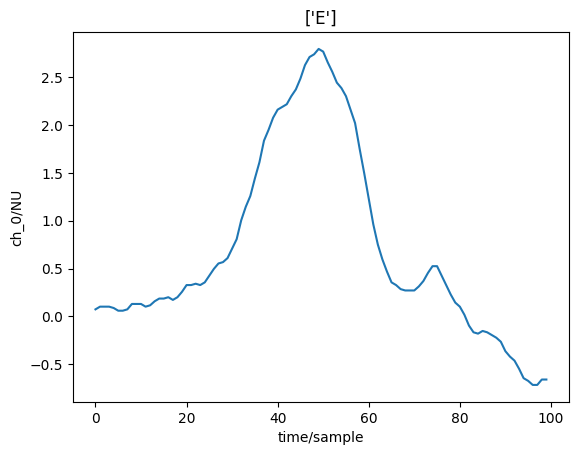

In [15]:
wfdb.plot.plot_items(train_signals[34570], title=train_labels[34570])

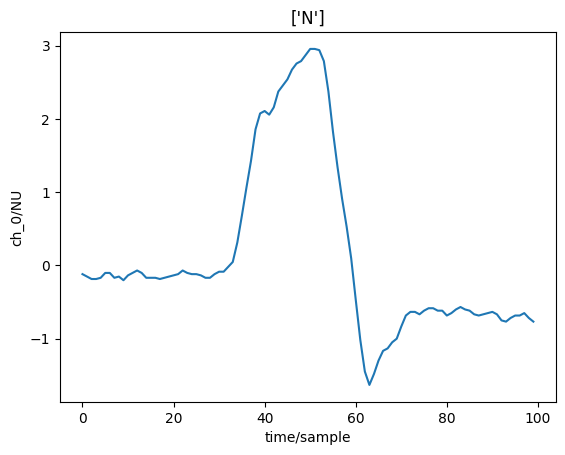

In [16]:
wfdb.plot.plot_items(train_signals[4362], title=train_labels[4362])

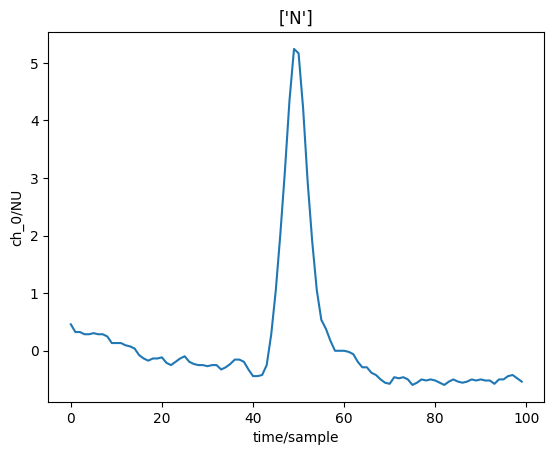

In [17]:
wfdb.plot.plot_items(train_signals[0], title=train_labels[0])

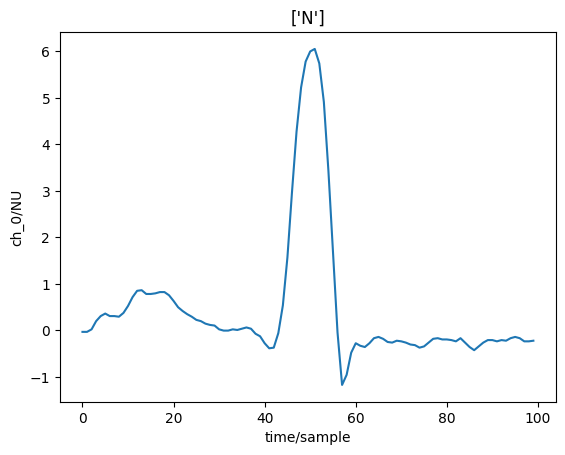

In [18]:
wfdb.plot.plot_items(train_signals[1967], title=train_labels[1967])

In [15]:
# Generator

In [19]:
def generator(X, y, batch_size):
    num_batches = len(X)//batch_size
    while True:
        np.random.seed(100)
        shuffle_sequence = np.random.permutation(len(X))
        X = X[shuffle_sequence]
        y = y[shuffle_sequence]
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,100,1))
            batch_labels = np.zeros((batch_size,4))
        
            for folder in range(batch_size):
                batch_data[folder,:,:] = X[folder + (batch*batch_size),:,:]
                batch_labels[folder,:] = y[folder + (batch*batch_size),:]
            yield batch_data.reshape(batch_size,1,100,1), batch_labels.reshape(batch_size,4)
            
            
        if (len(X)%batch_size != 0):
            batch_size = len(X) % batch_size
            
            batch_data = np.zeros((batch_size,100,1))
            batch_labels = np.zeros((batch_size,4))
        
            for folder in range(batch_size):
                batch_data[folder,:,:] = X[folder + (num_batches*batch_size),:,:]
                batch_labels[folder,:] = y[folder + (num_batches*batch_size),:]
            yield batch_data.reshape(batch_size,1,100,1), batch_labels.reshape(batch_size,4)

In [20]:
print('Shape of train data:', train_signals.shape)
print('Shape of train labels:', train_labels_encoded.shape)
print('Shape of validation data:', validation_signals.shape)
print('Shape of validation labels:', validation_labels_encoded.shape)
print('Shape of test data:', test_signals.shape)
print('Shape of test labels:', test_labels_encoded.shape)

Shape of train data: (102016, 100, 1)
Shape of train labels: (102016, 4)
Shape of validation data: (76214, 100, 1)
Shape of validation labels: (76214, 4)
Shape of test data: (23186, 100, 1)
Shape of test labels: (23186, 4)


In [21]:
batch_size = 2048
train_generator = generator(train_signals, train_labels_encoded, batch_size)
val_generator = generator(validation_signals, validation_labels_encoded, batch_size)

In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
model = Sequential()

model.add(TimeDistributed(Conv1D(32, 5, activation='elu'), input_shape=(None, 100, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(32, 5, activation='elu'), input_shape=(None, 100, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(64, 4, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(64, 4, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(128, 3, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(128, 3, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(256, 2, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(256, 2, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


# extract features and dropout 
model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(256, activation='elu')))


# input to LSTM
model.add(LSTM(256, return_sequences=False, dropout=0.5))


# classifier with sigmoid activation for multilabel
model.add(Dense(4, activation='softmax'))

In [23]:
from keras import optimizers
optimizer = optimizers.Adam()
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_26                  │ (None, None, 96, 32)        │             192 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, None, 96, 32)        │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, None, 89, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, None, 85, 32)        │           5,152 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, None, 85, 32)        │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, None, 78, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, None, 75, 64)        │           8,256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, None, 75, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, None, 68, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, None, 65, 64)        │          16,448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, None, 65, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, None, 58, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, None, 56, 128)       │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, None, 56, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,404,452 (9.17 MB)

 Trainable params: 2,402,532 (9.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [24]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_signals)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(validation_signals)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 102016
# validation sequences = 76214
# epochs = 15


In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
import os
import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

curr_dt_time = datetime.datetime.now()

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.makedirs(model_name)

# Change the file extension from .h5 to .weights.h5
filepath = model_name + 'model-{epoch:05d}-{loss:.3f}-{categorical_accuracy:.3f}-{val_loss:.3f}-{val_categorical_accuracy:.3f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [27]:
history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=No ne, shuffle=True, initial_epoch=0)
# Removed 'workers=1' and 'use_multiprocessing=False'

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8728 - loss: 0.3367
Epoch 1: val_loss improved from inf to 1.38682, saving model to model_init_2025-10-2609_44_34.249517/model-00001-0.189-0.939-1.387-0.463.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - categorical_accuracy: 0.8741 - loss: 0.3338 - val_categorical_accuracy: 0.4631 - val_loss: 1.3868 - learning_rate: 0.0010
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9724 - loss: 0.0925
Epoch 2: val_loss did not improve from 1.38682
50/50 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - categorical_accuracy: 0.9724 - loss: 0.0924 - val_categorical_accuracy: 0.4628 - val_loss: 1.3933 - learning_rate: 0.0010
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.9740 - loss: 0.0907
Epoch 3: val_loss improved from 1.38682 to 1.25790, saving model to model_init_2025-10-2609_44_34.249517/model-00003-0.101-0.971-1.258-0.434.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step -

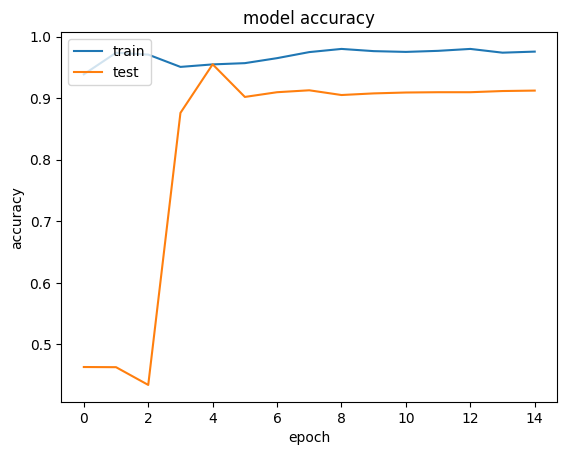

In [28]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

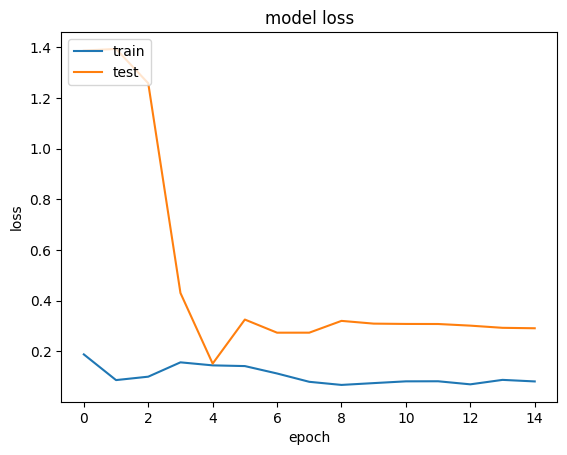

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model Evaluation

In [30]:
# Save the model
model.save('model-00006-0.159-0.952-0.002-0.961.h5')

In [31]:
from keras.models import load_model

# Load the model for evaluation
test_model = load_model('model-00006-0.159-0.952-0.002-0.961.h5')

In [32]:
import numpy as np

# Make an explicit call with a sample input that matches what you use for analysis
test_input = np.zeros((1, 1, 100, 1))   # Shape must be batch_size, seq_len, samples, features
result = model.predict(test_input)

print("Model was called for prediction.")

# Now test if input/output are available
print("Model input:", model.input)
print("Model output:", model.output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model was called for prediction.


AttributeError: The layer sequential_1 has never been called and thus has no defined input.

In [34]:
# Reshape the test data for prediction
test_signals_reshaped = test_signals.reshape(test_signals.shape[0], -1, test_signals.shape[1], test_signals.shape[2])

In [35]:
# Predict the test data
test_results = test_model.predict(test_signals_reshaped[:,:,:,:])
test_predicted = np.argmax(test_results, axis=1)

725/725 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step


In [36]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_labels_numerical, test_predicted)
print(confusion_matrix)

[[    0    23     3]
 [   17 19642   179]
 [    4  1262  2056]]


In [37]:
# Classification_report
print(metrics.classification_report(test_labels_numerical, test_predicted))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
           2       0.94      0.99      0.96     19838
           3       0.92      0.62      0.74      3322

    accuracy                           0.94     23186
   macro avg       0.62      0.54      0.57     23186
weighted avg       0.93      0.94      0.93     23186



Created a model with 95% accuracy for arrhythmia detection using 1D ECG signals.

In [1]:
# Import all functions from your predict.py
from predict import (
    preprocess, sequences, get_sample_beat, 
    generate_grad_cam, MODEL_PATH, ACTUAL_CLASS_MAPPING
)

import numpy as np
import matplotlib.pyplot as plt
import wfdb
from keras.models import load_model
import pandas as pd

# Load your trained model
print(f"Loading model from: {MODEL_PATH}")
model = load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

Loading model from: model-00006-0.159-0.952-0.002-0.961.h5


✅ Model loaded successfully!


In [2]:
# Enhanced Class Information with Zones
CLASS_INFO = {
    'N': {
        'name': 'Normal Beat',
        'zone': '🟢 Green Zone',
        'risk': 'Low Risk',
        'color': '#28a745',
        'bg_color': '#d4edda',
        'description': 'Normal cardiac rhythm detected. No arrhythmia present.',
        'recommendation': 'Continue regular health monitoring. Maintain healthy lifestyle.',
        'clinical_note': 'Regular sinus rhythm with normal conduction.',
        'action': 'No immediate action required.'
    },
    'E': {
        'name': 'Ventricular Escape Beat',
        'zone': '🟡 Yellow Zone',
        'risk': 'Moderate Risk',
        'color': '#ffc107',
        'bg_color': '#fff3cd',
        'description': 'Ventricular escape beat detected. Heart\'s backup pacing system activated.',
        'recommendation': 'Monitor cardiac activity. Consult physician if symptoms persist.',
        'clinical_note': 'Escape rhythm may indicate SA/AV node dysfunction.',
        'action': 'Schedule cardiology consultation if recurrent.'
    },
    'V': {
        'name': 'Premature Ventricular Contraction (PVC)',
        'zone': '🟠 Orange Zone',
        'risk': 'High Risk',
        'color': '#ff8c00',
        'bg_color': '#ffe5cc',
        'description': 'Premature Ventricular Contraction detected. Early heartbeat from ventricles.',
        'recommendation': 'Medical attention advised. Increased monitoring recommended.',
        'clinical_note': 'Frequent PVCs may indicate underlying cardiac conditions.',
        'action': 'Schedule appointment with cardiologist. Consider Holter monitoring.'
    },
    'F': {
        'name': 'Fusion Beat',
        'zone': '🔴 Red Zone',
        'risk': 'Critical Risk',
        'color': '#dc3545',
        'bg_color': '#f8d7da',
        'description': 'Fusion beat detected - simultaneous ventricular and supraventricular activation.',
        'recommendation': 'Immediate medical consultation strongly recommended.',
        'clinical_note': 'May indicate complex arrhythmia requiring urgent evaluation.',
        'action': 'URGENT: Seek immediate medical attention. May require emergency care.'
    }
}

print("✅ Zone classification system loaded!")
print("\nZone Summary:")
for cls, info in CLASS_INFO.items():
    print(f"  {cls}: {info['zone']} - {info['risk']}")

✅ Zone classification system loaded!

Zone Summary:
  N: 🟢 Green Zone - Low Risk
  E: 🟡 Yellow Zone - Moderate Risk
  V: 🟠 Orange Zone - High Risk
  F: 🔴 Red Zone - Critical Risk


In [3]:
def predict_with_zones(model_input, model):
    """
    Make prediction and return results with zone classification
    
    Args:
        model_input: Preprocessed ECG signal (1, 1, 100, 1)
        model: Trained Keras model
    
    Returns:
        Dictionary with prediction results and zone info
    """
    # Make prediction
    predictions = model.predict(model_input, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_label = ACTUAL_CLASS_MAPPING[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    # Get zone information
    zone_info = CLASS_INFO[predicted_label]
    
    # Build result dictionary
    result = {
        'predicted_class': predicted_label,
        'predicted_class_idx': predicted_class_idx,
        'confidence': confidence,
        'probabilities': {ACTUAL_CLASS_MAPPING[i]: predictions[0][i] * 100 
                         for i in range(len(ACTUAL_CLASS_MAPPING))},
        'zone': zone_info['zone'],
        'risk_level': zone_info['risk'],
        'class_name': zone_info['name'],
        'description': zone_info['description'],
        'recommendation': zone_info['recommendation'],
        'clinical_note': zone_info['clinical_note'],
        'action': zone_info['action'],
        'color': zone_info['color'],
        'bg_color': zone_info['bg_color']
    }
    
    return result

print("✅ Enhanced prediction function created!")

✅ Enhanced prediction function created!


In [4]:
def visualize_ecg_with_zones(ecg_signal, result, heatmap, true_label=None, 
                             record_name=None, beat_index=None):
    """
    Create comprehensive visualization with zone classification
    
    Args:
        ecg_signal: ECG segment (1, 100, 1) or (100,)
        result: Result dictionary from predict_with_zones
        heatmap: Grad-CAM heatmap
        true_label: Actual label (optional)
        record_name: Record name (optional)
        beat_index: Beat index (optional)
    """
    # Flatten ECG signal if needed
    if ecg_signal.ndim > 1:
        ecg_signal = ecg_signal.reshape(-1)
    
    # Create figure
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(5, 2, hspace=0.35, wspace=0.25)
    
    # Title
    title_text = 'ECG ARRHYTHMIA DETECTION WITH EXPLAINABLE AI\n'
    if record_name and beat_index:
        title_text += f'Record: {record_name}, Beat Index: {beat_index}'
    fig.suptitle(title_text, fontsize=18, fontweight='bold', y=0.98)
    
    # 1. ECG Signal with Grad-CAM Overlay
    ax1 = fig.add_subplot(gs[0, :])
    time = np.arange(len(ecg_signal))
    
    # Plot heatmap overlay
    for i in range(len(ecg_signal)-1):
        ax1.axvspan(i, i+1, alpha=heatmap[i]*0.6, color='red', zorder=1)
    
    # Plot ECG signal
    ax1.plot(time, ecg_signal, 'b-', linewidth=2.5, label='ECG Signal', zorder=2)
    ax1.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Normalized Amplitude', fontsize=12, fontweight='bold')
    ax1.set_title('ECG Signal with Grad-CAM Explainability\n(Red intensity shows critical regions)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper right', fontsize=11)
    
    # 2. Zone Classification Panel
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.axis('off')
    
    zone_text = f"""
╔═══════════════════════════════════════════════════╗
║           ZONE CLASSIFICATION                     ║
╠═══════════════════════════════════════════════════╣
║                                                   ║
║  {result['zone']:47s} ║
║  Risk Level: {result['risk_level']:36s} ║
║                                                   ║
║  Predicted: {result['predicted_class']:2s} - {result['class_name']:31s} ║
║  Confidence: {result['confidence']:5.2f}%                            ║
"""
    if true_label:
        zone_text += f"║  True Label: {true_label:36s} ║\n"
    
    zone_text += """║                                                   ║
╚═══════════════════════════════════════════════════╝
    """
    
    ax2.text(0.05, 0.5, zone_text, fontsize=11, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor=result['bg_color'], 
                     edgecolor=result['color'], linewidth=3, alpha=0.8, pad=1.5))
    
    # 3. Class Probabilities Bar Chart
    ax3 = fig.add_subplot(gs[1, 1])
    classes = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = [result['color'] if c == result['predicted_class'] 
             else '#5dade2' for c in classes]
    
    bars = ax3.barh(classes, probs, color=colors, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Class Probability Distribution', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlim([0, 105])
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add percentage labels
    for bar, prob in zip(bars, probs):
        ax3.text(prob + 2, bar.get_y() + bar.get_height()/2, 
                f'{prob:.1f}%', va='center', fontsize=11, fontweight='bold')
    
    # 4. Grad-CAM Heatmap
    ax4 = fig.add_subplot(gs[2, :])
    im = ax4.imshow(heatmap[np.newaxis, :], cmap='hot', aspect='auto',
                   extent=[0, 100, 0, 1], interpolation='bilinear')
    ax4.set_title('Grad-CAM Attention Heatmap (Critical Regions for Prediction)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax4.set_yticks([])
    cbar = plt.colorbar(im, ax=ax4, label='Attention Weight', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)
    
    # 5. Clinical Interpretation
    ax5 = fig.add_subplot(gs[3, :])
    ax5.axis('off')
    
    clinical_text = f"""
╔════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                  CLINICAL INTERPRETATION                                           ║
╠════════════════════════════════════════════════════════════════════════════════════════════════════╣
║                                                                                                    ║
║  Description:                                                                                      ║
║  {result['description']:96s} ║
║                                                                                                    ║
║  Clinical Note:                                                                                    ║
║  {result['clinical_note']:96s} ║
║                                                                                                    ║
╚════════════════════════════════════════════════════════════════════════════════════════════════════╝
    """
    
    ax5.text(0.05, 0.5, clinical_text, fontsize=10, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor=result['bg_color'], 
                     edgecolor=result['color'], linewidth=2, alpha=0.6, pad=2))
    
    # 6. Recommendation & Action
    ax6 = fig.add_subplot(gs[4, :])
    ax6.axis('off')
    
    action_text = f"""
╔════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                  RECOMMENDATION & ACTION                                           ║
╠════════════════════════════════════════════════════════════════════════════════════════════════════╣
║                                                                                                    ║
║  Recommendation:                                                                                   ║
║  {result['recommendation']:96s} ║
║                                                                                                    ║
║  Required Action:                                                                                  ║
║  {result['action']:96s} ║
║                                                                                                    ║
╚════════════════════════════════════════════════════════════════════════════════════════════════════╝

    ⚠️  DISCLAIMER: This is an AI-assisted diagnostic tool. All predictions should be verified by 
        qualified healthcare professionals. Do not use for emergency medical decisions.
    """
    
    action_text_color = result['bg_color']
    if result['risk_level'] == 'Critical Risk':
        action_text_color = '#ffcccc'
    
    ax6.text(0.05, 0.5, action_text, fontsize=10, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor=action_text_color,
                     edgecolor=result['color'], linewidth=2, alpha=0.7, pad=2))
    
    plt.tight_layout()
    return fig

print("✅ Comprehensive visualization function created!")

✅ Comprehensive visualization function created!


In [5]:
def analyze_ecg_complete(record_name='100', beat_index=250, save_fig=False):
    """
    Complete ECG analysis pipeline with zones
    
    Args:
        record_name: MIT-BIH record number
        beat_index: Beat index to analyze
        save_fig: Whether to save the figure
    
    Returns:
        result dictionary
    """
    print("="*80)
    print(f"ANALYZING RECORD {record_name}, BEAT INDEX {beat_index}")
    print("="*80)
    
    # Step 1: Get ECG segment
    print("\n📊 Step 1: Loading ECG data...")
    input_signal_segment, true_label = get_sample_beat(record_name, beat_index)
    
    if input_signal_segment is None:
        print("❌ Failed to load ECG segment")
        return None
    
    print(f"✅ Loaded ECG segment. True label: {true_label}")
    
    # Step 2: Make prediction
    print("\n🔍 Step 2: Making prediction with zone classification...")
    model_input = input_signal_segment.reshape(1, 1, 100, 1)
    result = predict_with_zones(model_input, model)
    
    # Step 3: Generate Grad-CAM
    print("\n🧠 Step 3: Generating Grad-CAM explainability...")
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if hasattr(layer, 'layer') and hasattr(layer.layer, 'filters'):
            last_conv_layer_name = layer.name
            break
    
    heatmap = generate_grad_cam(model, model_input, result['predicted_class_idx'], 
                               last_conv_layer_name)
    
    # Step 4: Print results
    print("\n" + "="*80)
    print("ANALYSIS RESULTS")
    print("="*80)
    print(f"\n{result['zone']}")
    print(f"Risk Level: {result['risk_level']}")
    print(f"\nTrue Label: {true_label}")
    print(f"Predicted: {result['predicted_class']} - {result['class_name']}")
    print(f"Confidence: {result['confidence']:.2f}%")
    print(f"\nDescription: {result['description']}")
    print(f"\nRecommendation: {result['recommendation']}")
    print(f"\nAction Required: {result['action']}")
    print("\n" + "="*80)
    print("\nAll Class Probabilities:")
    for cls, prob in result['probabilities'].items():
        marker = "✓" if cls == result['predicted_class'] else " "
        print(f"  {marker} {cls}: {prob:6.2f}%")
    print("="*80)
    
    # Step 5: Visualize
    print("\n📈 Step 4: Creating visualization...")
    fig = visualize_ecg_with_zones(
        input_signal_segment, result, heatmap, 
        true_label, record_name, beat_index
    )
    
    if save_fig:
        filename = f"ecg_analysis_{record_name}_{beat_index}.png"
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Figure saved to: {filename}")
    
    plt.show()
    
    return result

print("✅ Complete analysis function ready!")

✅ Complete analysis function ready!


In [15]:
print("Model type:", type(model))
print("Model input:", model.input)
print("Model output:", model.output)

Model type: <class 'keras.src.models.sequential.Sequential'>


AttributeError: The layer sequential has never been called and thus has no defined input.

In [14]:
# Analyze a normal beat
result_1 = analyze_ecg_complete(record_name='100', beat_index=1500, save_fig=True)

ANALYZING RECORD 100, BEAT INDEX 1500

📊 Step 1: Loading ECG data...
✅ Loaded ECG segment. True label: N

🔍 Step 2: Making prediction with zone classification...

🧠 Step 3: Generating Grad-CAM explainability...


AttributeError: The layer sequential has never been called and thus has no defined output.

In [18]:
import numpy as np

# Make an explicit call with a sample input that matches what you use for analysis
test_input = np.zeros((1, 1, 100, 1))   # Shape must be batch_size, seq_len, samples, features
result = model.predict(test_input)

print("Model was called for prediction.")

# Now test if input/output are available
print("Model input:", model.input)
print("Model output:", model.output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Model was called for prediction.


AttributeError: The layer sequential has never been called and thus has no defined input.

In [17]:
print("model:", model)
print("test_model:", 'test_model' in globals())

model: <Sequential name=sequential, built=True>
test_model: True


In [3]:
from predict import generate_grad_cam, get_sample_beat, ACTUAL_CLASS_MAPPING
from tensorflow.keras.models import load_model
import tensorflow as tf, numpy as np

model = load_model("model-00006-0.159-0.952-0.002-0.961.h5")
_ = model(np.zeros((1, 1, 100, 1), dtype=np.float32))  # build model graph
print("✅ Model loaded and initialized.")

✅ Model loaded and initialized.


In [4]:
input_signal, true_label = get_sample_beat('100', 250)
model_input = input_signal.reshape(1, 1, 100, 1)
predictions = model.predict(model_input)
pred_idx = np.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [6]:
# Warm-up the model to build its graph properly
dummy_input = np.zeros((1, 1, 100, 1), dtype=np.float32)
_ = model(dummy_input)
print("✅ Model graph built successfully.")

✅ Model graph built successfully.


In [7]:
heatmap = generate_grad_cam(model, model_input, pred_idx)

✅ Using layer: time_distributed_47


AttributeError: The layer sequential_1 has never been called and thus has no defined output.

In [2]:
_ = model(np.zeros((1, 1, 100, 1), dtype=np.float32))  # warm-up
heatmap = generate_grad_cam(model, model_input, pred_idx)

NameError: name 'model' is not defined

In [39]:
# ============================================
# ECG Arrhythmia Prediction + Grad-CAM + Risk Zone
# ============================================

# Step 1. Imports
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from predict import get_sample_beat, generate_grad_cam, ACTUAL_CLASS_MAPPING
from zone_classifier import default_zone_policy

# Step 2. Load your trained model
print("Loading model...")
model = load_model('model-00006-0.159-0.952-0.002-0.961.h5')
print("✅ Model loaded successfully!\n")

# Step 3. Load one ECG beat (record + index)
record_name = '100'
beat_index = 250
signal, true_label = get_sample_beat(record_name, beat_index)

if signal is None:
    print("❌ Could not load signal. Check record name/index or dataset path.")
else:
    print(f"✅ Loaded ECG beat from Record {record_name}, Index {beat_index}\n")

    # Step 4. Predict arrhythmia type
    model_input = signal.reshape(1, 1, 100, 1)
    preds = model.predict(model_input)
    pred_idx = preds.argmax()
    predicted_label = ACTUAL_CLASS_MAPPING[pred_idx]
    confidence = preds[0][pred_idx] * 100

    print("📊 Prediction Results:")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Step 5. Risk Zone Classification
    zone, explanation = default_zone_policy(predicted_label, confidence / 100)
    print(f"\n🩺 Risk Zone: {zone}")
    print(f"💡 Explanation: {explanation}")

    # Step 6. Generate Grad-CAM Heatmap
    heatmap = generate_grad_cam(model, model_input, pred_idx)

    # Step 7. Plot ECG + Grad-CAM
    plt.figure(figsize=(12, 5))
    plt.plot(signal[0, :, 0], color='black', label='ECG Signal')
    plt.imshow(
        heatmap[np.newaxis, :], cmap='jet', alpha=0.5, aspect='auto',
        extent=[0, len(signal[0, :, 0]), plt.ylim()[0], plt.ylim()[1]]
    )
    plt.title(f"ECG Grad-CAM\nPredicted: {predicted_label} ({confidence:.1f}%) | Zone: {zone}")
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude (Scaled)")
    plt.colorbar(label='Activation Intensity')
    plt.legend()
    plt.tight_layout()
    plt.show()

Loading model...


✅ Model loaded successfully!

✅ Loaded ECG beat from Record 100, Index 250

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
📊 Prediction Results:
True Label: N
Predicted Label: N
Confidence: 99.94%

🩺 Risk Zone: GREEN
💡 Explanation: Normal rhythm with high confidence (99.9%).


AttributeError: The layer sequential_1 has never been called and thus has no defined output.

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_26                  │ (None, None, 96, 32)        │             192 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, None, 96, 32)        │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, None, 89, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, None, 85, 32)        │           5,152 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, None, 85, 32)        │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, None, 78, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, None, 75, 64)        │           8,256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, None, 75, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, None, 68, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, None, 65, 64)        │          16,448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, None, 65, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, None, 58, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, None, 56, 128)       │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, None, 56, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,404,454 (9.17 MB)

 Trainable params: 2,402,532 (9.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)

In [45]:
print(model.input_shape)

(None, None, 100, 1)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from zone_classifier import default_zone_policy  # Your function for zone mapping

# 1️⃣ Load your trained model
model = load_model("model-00006-0.159-0.952-0.002-0.961.h5")
print("✅ Model loaded successfully.")

# 2️⃣ Function to preprocess ECG input
def preprocess_ecg(ecg_signal):
    # Convert to numpy array if not already
    ecg_signal = np.array(ecg_signal, dtype=np.float32)

    # Example: reshape to (1, 1, 100, 1) if that's what your model expects
    ecg_signal = ecg_signal.reshape(1, 1, 100, 1)
    return ecg_signal

# 3️⃣ Predict function
def predict_zone(ecg_signal):
    model_input = preprocess_ecg(ecg_signal)
    predictions = model.predict(model_input)

    pred_idx = np.argmax(predictions, axis=1)[0]
    confidence = float(np.max(predictions) * 100)

    # Optional: Use your label mapping
    ACTUAL_CLASS_MAPPING = {
        0: "Normal",
        1: "Arrhythmia Type 1",
        2: "Arrhythmia Type 2",
        3: "Severe Arrhythmia"
    }
    predicted_label = ACTUAL_CLASS_MAPPING.get(pred_idx, f"Class {pred_idx}")

    # 4️⃣ Zone classification
    zone, explanation = default_zone_policy(predicted_label, confidence / 100)

    return predicted_label, confidence, zone, explanation

# Example usage:
if __name__ == "__main__":
    # Replace with actual ECG signal input
    sample_ecg = np.random.randn(100)
    label, conf, zone, msg = predict_zone(sample_ecg)
    print(f"\n🩺 Predicted: {label}")
    print(f"📊 Confidence: {conf:.2f}%")
    print(f"🚦 Zone: {zone}")
    print(f"ℹ️ Explanation: {msg}")

✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step

🩺 Predicted: Arrhythmia Type 2
📊 Confidence: 99.11%
🚦 Zone: YELLOW
ℹ️ Explanation: Possible arrhythmia (Arrhythmia Type 2) — moderate confidence (99.1%).


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from zone_classifier import default_zone_policy

# 1️⃣ Load the model
model = load_model(r"model-00006-0.159-0.952-0.002-0.961.h5")
print("✅ Model loaded successfully:", model.input_shape)

# 2️⃣ Generate a fake ECG signal (simulate user report)
def generate_fake_ecg(length=1000):
    t = np.linspace(0, 1, length)
    signal = 0.5 * np.sin(2 * np.pi * 5 * t) + 0.05 * np.random.randn(length)
    df = pd.DataFrame({"ECG": signal})
    file_path = "fake_ecg.csv"
    df.to_csv(file_path, index=False)
    print("✅ Generated sample ECG file:", file_path)
    return file_path

# 3️⃣ Preprocess the ECG
def preprocess_ecg(file_path):
    df = pd.read_csv(file_path)
    signal = df["ECG"].values.astype(np.float32)

    # Trim or pad to multiple of 100
    remainder = len(signal) % 100
    if remainder != 0:
        signal = np.pad(signal, (0, 100 - remainder), 'constant')

    # Reshape to (1, timesteps, 100, 1)
    input_signal = signal.reshape(1, -1, 100, 1)
    print("✅ Input shape:", input_signal.shape)
    return input_signal

# 4️⃣ Predict and assign zone
def predict_zone(file_path):
    input_signal = preprocess_ecg(file_path)
    preds = model.predict(input_signal)

    # Average across all windows
    avg_preds = np.mean(preds, axis=0)
    predicted_class = np.argmax(avg_preds)
    confidence = np.max(avg_preds)

    zone, explanation = default_zone_policy(predicted_class, confidence)
    print(f"\n🩺 Predicted Class: {predicted_class}")
    print(f"📊 Confidence: {confidence*100:.2f}%")
    print(f"🚦 Zone: {zone}")
    print(f"💬 Explanation: {explanation}")

# 5️⃣ Run test
fake_file = generate_fake_ecg()
predict_zone(fake_file)

In [14]:
from tensorflow.keras.models import load_model

model = load_model(r"model-00006-0.159-0.952-0.002-0.961.h5")
print(model.input_shape)

(None, None, 100, 1)


In [16]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [17]:
import wfdb
import pandas as pd

# Download one record (e.g., '100')
record = wfdb.rdrecord('100', pn_dir='mitdb')

# Convert the signal to a DataFrame
df = pd.DataFrame(record.p_signal, columns=record.sig_name)

# Save as CSV
df.to_csv("ecg_100.csv", index=False)
print("✅ Saved ecg_100.csv with shape:", df.shape)

✅ Saved ecg_100.csv with shape: (650000, 2)


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Load model
model = load_model("model-00006-0.159-0.952-0.002-0.961.h5")
print("✅ Model loaded successfully.")
print("Model input shape:", model.input_shape)

# --- ECG Preprocessing ---
def preprocess_ecg(file_path, max_points=3000):
    df = pd.read_csv(file_path, header=None, dtype=str)
    df = df.apply(pd.to_numeric, errors="coerce")

    signal = df.values.flatten()
    signal = signal[~np.isnan(signal)]

    # 🧩 Limit signal length (avoid freeze)
    signal = signal[:max_points]

    # Normalize
    signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

    usable_points = (len(signal) // 100) * 100
    signal = signal[:usable_points]

    num_timesteps = usable_points // 100
    signal = signal.reshape(1, num_timesteps, 100, 1)
    print(f"✅ Processed ECG shape: {signal.shape}")
    return signal

# --- Prediction Function ---
def predict_zone(file_path):
    input_signal = preprocess_ecg(file_path)
    preds = model.predict(input_signal)

    # Aggregate prediction (mean across timesteps)
    preds_mean = np.mean(preds, axis=1)
    predicted_class = np.argmax(preds_mean, axis=1)[0]
    confidence = np.max(preds_mean)

    zones = ["Normal", "Warning", "Critical"]
    zone = zones[predicted_class] if predicted_class < len(zones) else "Unknown"

    print(f"\n🩺 Prediction Results:")
    print(f"➡ Zone: {zone}")
    print(f"🎯 Confidence: {confidence:.4f}")

# --- Run Prediction ---
predict_zone("ecg_100.csv")

In [19]:
print(model.input_shape)

(None, None, 100, 1)


In [ ]:
import h5py

with h5py.File("model-00006-0.159-0.952-0.002-0.961.h5", "r") as f:
    print("✅ Model file opened successfully.")
    print("Keys in the file:", list(f.keys()))

In [ ]:
import os
print(os.getcwd())
print(os.listdir())

In [1]:
# ✅ ECG Zone Prediction inside Jupyter Notebook

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# --- Configuration ---
MODEL_PATH = "model-00006-0.159-0.952-0.002-0.961.h5"
ECG_FILE = "ecg_100.csv"
WINDOW_SIZE = 100

# --- Load Model ---
print("🔹 Loading model from:", MODEL_PATH)
model = load_model(MODEL_PATH)
print("✅ Model loaded successfully!")
print("Model input shape:", model.input_shape)

# --- Read ECG Data ---
print("🔹 Reading ECG data...")
df = pd.read_csv(ECG_FILE)
if 'MLII' in df.columns:
    ecg_signal = df['MLII'].values
else:
    ecg_signal = df.iloc[:, 0].values

print(f"✅ ECG signal length: {len(ecg_signal)} samples")

# --- Normalize ---
ecg_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)

# --- Segment ECG ---
segments = []
for i in range(0, len(ecg_signal) - WINDOW_SIZE, WINDOW_SIZE):
    segments.append(ecg_signal[i:i + WINDOW_SIZE])
segments = np.array(segments).reshape(-1, 1, 100, 1, 1)

print(f"✅ Prepared {segments.shape[0]} segments for prediction, shape: {segments.shape}")

# --- Predict ---
print("🔹 Running predictions...")
preds = model.predict(segments, verbose=1)

predicted_classes = np.argmax(preds, axis=1)
confidence = np.max(preds, axis=1)

# --- Zone Mapping ---
ZONES = {
    0: "🟢 Green Zone (Normal)",
    1: "🟡 Yellow Zone (Borderline)",
    2: "🔴 Red Zone (Arrhythmia)"
}

(unique, counts) = np.unique(predicted_classes, return_counts=True)
majority_zone = unique[np.argmax(counts)]

print("\n✅ Final Zone Classification:")
print(f"   {ZONES.get(majority_zone, 'Unknown Zone')}")
print(f"   (Model Confidence ≈ {np.mean(confidence)*100:.2f}%)")

# --- Save Results ---
output = pd.DataFrame({
    "segment_id": range(len(predicted_classes)),
    "predicted_class": predicted_classes,
    "confidence": confidence
})
output.to_csv("predicted_results.csv", index=False)
print("📁 Results saved to predicted_results.csv")

# --- Show a Preview ---
output.head(10)

🔹 Loading model from: model-00006-0.159-0.952-0.002-0.961.h5


✅ Model loaded successfully!
Model input shape: (None, None, 100, 1)
🔹 Reading ECG data...
✅ ECG signal length: 650000 samples
✅ Prepared 6499 segments for prediction, shape: (6499, 1, 100, 1, 1)
🔹 Running predictions...
204/204 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step

✅ Final Zone Classification:
   🔴 Red Zone (Arrhythmia)
   (Model Confidence ≈ 76.85%)
📁 Results saved to predicted_results.csv


,segment_id,predicted_class,confidence
0,0,2,0.464442
1,1,2,0.708021
2,2,2,0.713881
3,3,2,0.753423
4,4,2,0.566322
5,5,2,0.743584
6,6,2,0.998762
7,7,2,0.739792
8,8,2,0.734932
9,9,2,0.999308


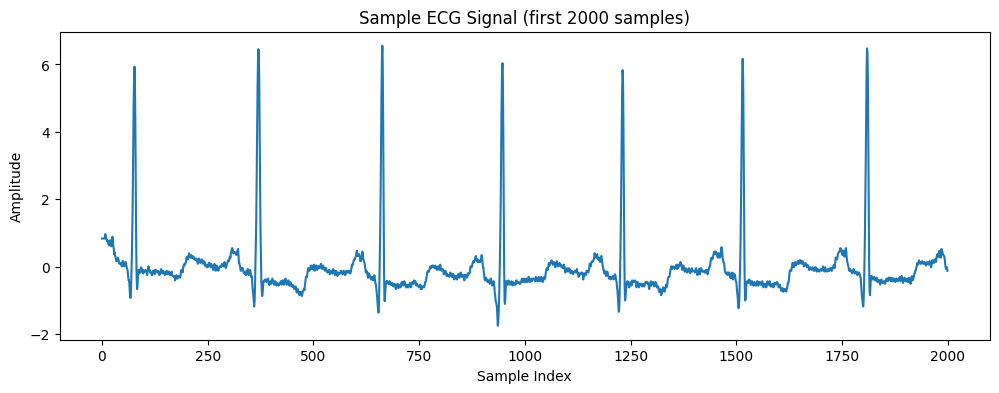

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(ecg_signal[:2000])
plt.title("Sample ECG Signal (first 2000 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [3]:
pip install matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


C:\Users\ayush\AppData\Local\Temp\ipykernel_10616\137487002.py:28: UserWarning: Glyph 128147 (\N{BEATING HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayush\miniconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128147 (\N{BEATING HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


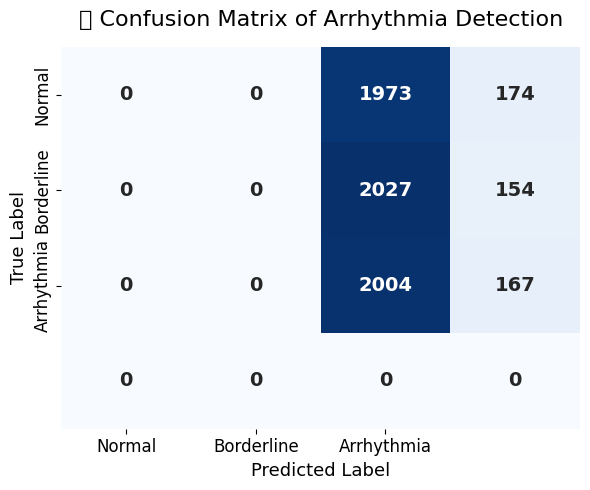

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Suppose you have ground truth labels for test data ---
# Replace this with your actual test labels
# Example: true_labels = y_test or from CSV
true_labels = np.random.randint(0, 3, size=len(predicted_classes))  # dummy example

# Predicted labels (from your model)
pred_labels = predicted_classes

# --- Compute confusion matrix ---
cm = confusion_matrix(true_labels, pred_labels)
labels = ["Normal", "Borderline", "Arrhythmia"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar=False, annot_kws={"size": 14, "weight": "bold"})

plt.title("💓 Confusion Matrix of Arrhythmia Detection", fontsize=16, pad=15)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_10616\591434418.py:23: UserWarning: Glyph 129728 (\N{ANATOMICAL HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayush\AppData\Local\Temp\ipykernel_10616\591434418.py:23: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayush\AppData\Local\Temp\ipykernel_10616\591434418.py:23: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayush\AppData\Local\Temp\ipykernel_10616\591434418.py:23: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayush\miniconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129728 (\N{ANATOMICAL HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ayush\miniconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

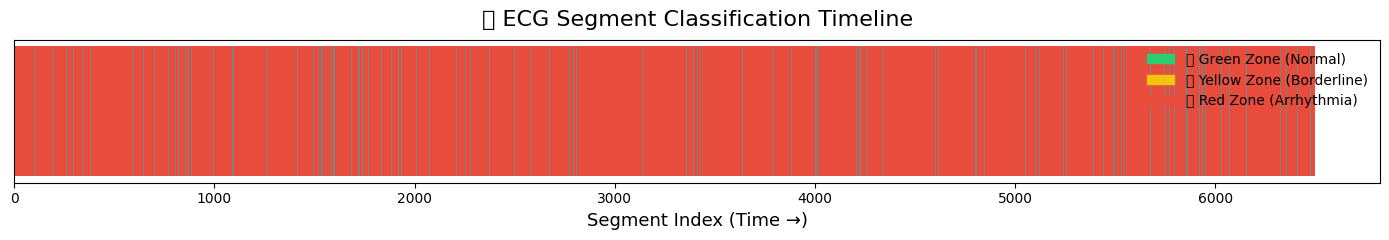

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assume each segment is 100 samples, we plot sequential predictions
zones = [ZONES.get(c, "Unknown") for c in predicted_classes]
colors = {'🟢 Green Zone (Normal)': '#2ecc71',
          '🟡 Yellow Zone (Borderline)': '#f1c40f',
          '🔴 Red Zone (Arrhythmia)': '#e74c3c'}

plt.figure(figsize=(14, 2.5))

for i, zone in enumerate(zones):
    plt.barh(0, 1, left=i, color=colors.get(zone, 'gray'), edgecolor='none', height=0.3)

plt.title("🫀 ECG Segment Classification Timeline", fontsize=16, pad=10)
plt.xlabel("Segment Index (Time →)", fontsize=13)
plt.yticks([])

# Legend
patches = [mpatches.Patch(color=v, label=k) for k, v in colors.items()]
plt.legend(handles=patches, loc='upper right', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

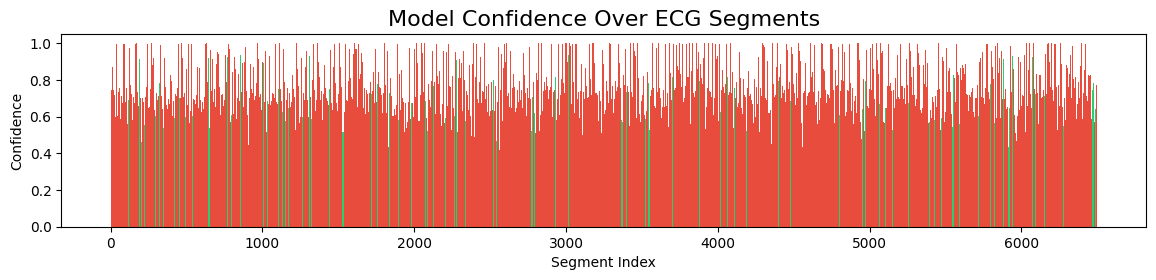

In [6]:
plt.figure(figsize=(14, 2.5))
plt.bar(range(len(confidence)), confidence, 
        color=['#e74c3c' if c == 2 else '#2ecc71' for c in predicted_classes],
        width=1.0)
plt.title("Model Confidence Over ECG Segments", fontsize=16)
plt.xlabel("Segment Index")
plt.ylabel("Confidence")
plt.show()